In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

/home/gautamsai_y/.conda/envs/rv-21/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
from experiment_configs.unet_fs_config import unet_orig_config, unet_resblocks_config, resnet18_unet_config
from experiment_configs.satmae_ft_config import satmae_ft_doubleupsampling_config, satmae_ft_lineardecoder_config
from experiment_configs.resnetmoco_ft_config import resnet18_moco_ft_config
config = unet_orig_config

In [3]:
from torch.utils.data import ConcatDataset

from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, warn_if_nan_in_raw_raster
from utils.data_management import observation_factory

from project_config import is_training, is_validation

from utils.visualizing import visualize_dataset, Visualizer


all_observations = observation_factory(gcp_client)
training_scenes = []
validation_scenes = []

for observation in all_observations:
    is_train = is_training(observation.name)
    is_val = is_validation(observation.name)

    assert not (is_train and is_val), "An observation cannot be in both training and validation"

    scene = observation_to_scene(config, observation)    
    if is_train:
        training_scenes.append(scene)
    elif is_val:
        validation_scenes.append(scene)
    else:
        print(f"Ignoring observation {observation.name}")


#all_scenes = training_scenes + validation_scenes
#for scene in all_scenes:
#    warn_if_nan_in_raw_raster(scene.raster_source)

training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes #random window sampling happens here
]
validation_datasets = [
    scene_to_validation_ds(config, scene) for scene in validation_scenes
]

train_dataset_merged = ConcatDataset(training_datasets)
# val_dataset_merged = ConcatDataset(validation_datasets)


2023-11-02 12:13:33:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/s2/Godavari_EastGodavari_81-84_16-66_2022-06-01_s2.tif.
2023-11-02 12:13:33:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/s1/Godavari_EastGodavari_81-84_16-66_2022-06-01_s1.tif.
2023-11-02 12:13:33:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/annotations/Godavari_EastGodavari_81-84_16-66_2022-06-01_annotations.geojson.


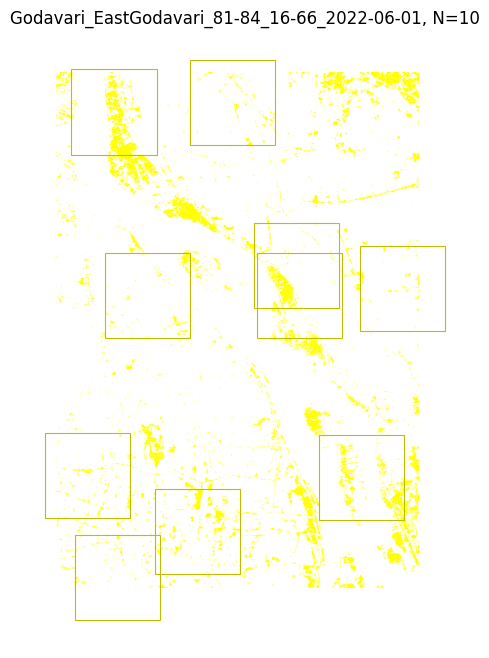

In [26]:
visualizer = Visualizer(config.s2_channels)
visualize_dataset(training_datasets, visualizer)

In [24]:
from os.path import expanduser

from models.model_factory import model_factory
from ml.optimizer_factory import optimizer_factory
from ml.learner import BinarySegmentationLearner
import torch

_, _, n_channels = training_datasets[0].scene.raster_source.shape
# model = model_factory(
#     config,
#     n_channels=n_channels,
# )
model = torch.nn.Conv2d(n_channels, 1, 1)

optimizer = optimizer_factory(config, model)

learner = BinarySegmentationLearner(
    config=config,
    model=model,
    optimizer=optimizer,
    train_ds=training_datasets[0],  # for development and debugging, use training_datasets[0] or similar to speed up
    valid_ds=training_datasets[0],  # for development and debugging, use training_datasets[1] or similar to speed up
    output_dir=expanduser("~/sandmining-watch/out/OUTPUT_DIR"),
)

learner.log_data_stats()

2023-11-02 13:07:32:rastervision: INFO - Loading weights from /home/gautamsai_y/sandmining-watch/out/OUTPUT_DIR/last-model.pth
2023-11-02 13:07:32:rastervision: INFO - train_ds: 10 items
2023-11-02 13:07:32:rastervision: INFO - valid_ds: 10 items


In [25]:
learner.train(epochs=1)

2023-11-02 13:07:33:rastervision: INFO - epoch: 0


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-02 13:07:37:rastervision: INFO - metrics:
{'100_f1': 0.0,
 '100_precision': 0.0,
 '100_recall': 0.0,
 '25_f1': 0.10045874863862991,
 '25_precision': 0.055330876260995865,
 '25_recall': 0.5447875261306763,
 '50_f1': 0.0,
 '50_precision': 0.0,
 '50_recall': 0.0,
 '75_f1': 0.0,
 '75_precision': 0.0,
 '75_recall': 0.0,
 'avg_f1': 0.8799828886985779,
 'avg_precision': 0.9700542092323303,
 'avg_recall': 0.8052170276641846,
 'epoch': 0,
 'other_f1': 0.8907838463783264,
 'other_precision': 0.9886882901191711,
 'other_recall': 0.8105222582817078,
 'sandmine_average_precision': tensor(0.1298, device='cuda:0'),
 'train_bce_loss': 0.06607884764671326,
 'train_dice_loss': 0.09712390899658203,
 'train_time': datetime.timedelta(seconds=1, microseconds=857976),
 'val_bce_loss': tensor(0.0669, device='cuda:0'),
 'val_dice_loss': tensor(0.0962, device='cuda:0'),
 'valid_time': datetime.timedelta(seconds=1, microseconds=894513)}
